# Machine Learning using Best Fourier Coefficients


### Importing the data 

In [1]:
%reset
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements 
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))


Keys: <KeysViewHDF5 ['Sensor_Data']>
    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements 
    and 6291 represents number of cycles.


### Converting into SI units 

In [3]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]

### Splitting data into training and testing data

Lifetime is represented with percentage values where 0 % means being brand-new and 100 % being broken. Firstly, target vector is created, which assumes linear correlation between cycle number and the degree of wear of the electro-mechanical cylinder.

(6291, 1)


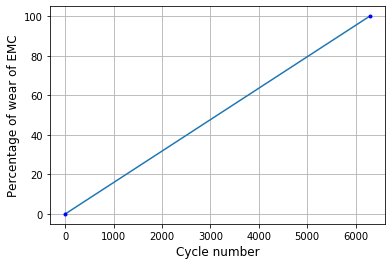

In [4]:
# Creating a target vector which will be used for correlation analysis.

target=list(np.zeros(6291))            # Making the target list which takes into account number of cycles, which-
for i in range(6291):                  # -goes from 0 to 100, and has "nCycles" elements. 
    target[i]=(i/6290)*100

target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "
print(target_matrix.shape)
plt.plot((np.array(target))*6290.0/100.0, target)
plt.xlabel("Cycle number", fontsize=12)
plt.ylabel("Percentage of wear of EMC", fontsize=12)
plt.grid()
plt.plot(6291, 100, '.', color='b')
plt.plot(0, 0, '.', color='b')



Now we need to split the raw data into training and testing data sets.
For that purpose, we use scikit.learn function train_test_split which will, in this case, choose randomly k % of the cycles into training data, and the rest of it will be used for validation. Function train_test_split is applied on target vector, and based on a selected cycles for both groups in target vector, those same cycles are extracted from the data set "sensor".

So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [5]:
#print(target_matrix)

from sklearn.model_selection import train_test_split

k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
target_train_vector, target_test_vector =train_test_split(target_matrix, test_size=1-k/100.)
#target_train_vector=target_train_vector.transpose()
#target_test_vector=target_test_vector.transpose()
print(target_train_vector.shape)
print(target_test_vector.shape)

target=list(target_train_vector[0])


Enter the percentage which will be used as a traning data (recommended is 80-90): 85
(5347, 1)
(944, 1)


In [6]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",    list 'sensor_train' ")
print("and it's target vector has length: ", target_train_vector.shape,",               'target_train_vector' \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",    list 'sensor_test' ")
print("and it's target vector has length: ", target_test_vector.shape,",               'target_test_vector' \n")


Traning data for one sensor has dimensions:  (2000, 5347) ,    list 'sensor_train' 
and it's target vector has length:  (5347, 1) ,               'target_train_vector' 

Testing data for one sensor has dimensions:  (2000, 944) ,    list 'sensor_test' 
and it's target vector has length:  (944, 1) ,               'target_test_vector' 



## Feature extraction
### Feature extraction using BFC

###### Steps:  
    
- transformation into frequency domain (FFT)
- choose amplitudes with highest average absolute value (the top 10%)


In this method of feature extraction, data is transformed into frequency domain using FFT function for discrete Fourier transform. More detail about FFT in (`1_FFT_and_Reconstruction.ipynb`)

This step an unsupervised extraction method (i.e. is done without knowledge of the cycle‘s group affiliation) and used is to reduce dimension for further steps.





###### A function is created, which takes as input: 
- data from one senzor "sensor",                                 
- number of samples "n_of_samples",                                    
- percentage of data to choose "N".

Function does fast Fourier transform and chooses N% of sprectrum with highest average of absolute values for each sensor independently. Average of absolute values for one frequency is calculated through all cycles.                                   


###### Function returns:
- "freq_of_sorted_values" matrix sized [1, N% of features (amplitudes)] where elements are frequencies which are choosen and store informations about frequencies in second function output.
- "sorted_values_matrix" sized [number of cycles, N% of features (amplitudes)] where row represents one cycle and columns are sorted by the average of absolute vales for each frequency (column).

In [7]:
def chooseAndReturnOrdered(sensor, n_of_samples, N): 
    x_measurements=range(sensor.shape[0])  # Number of measurements in time period.Working only inside the loop!
    x = np.true_divide(x_measurements, n_of_samples)      # Time values, can be used as real time axis.
    freq = np.fft.rfftfreq(x.size, 0.0005)                # Frequency axis, can be used for plotin in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor,n_of_samples,0)   # Ndarray of amplitudes after fourier transform.
    fft_matrix = pd.DataFrame(fft_amplitudes)             # Transforming amplitudes into data frame (matrix)-
    #-----------------------------------------------------# -where one column represents amplitudes of one-
    #-----------------------------------------------------# -cycle.
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.
    n_rows, n_columns = np.shape(fft_matrix)

    print("\nNumber of cycles is: %s, and number of features is: %s" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies. 
    
    # Calculating the average of absolute vales for each frequency (column).
    absolute_average_values_from_columns=(np.abs(fft_matrix)).mean()
    
    # Sorting the fft_matrix by the average of absolute vales for each frequency (column).
    fft_matrix=fft_matrix.reindex((np.abs(fft_matrix)).mean().sort_values(ascending=False).index, axis=1)
    print(np.shape(fft_matrix))
    
    # Choosing first N percent columns from sorted fft_matrix. 
    sorted_values_matrix=fft_matrix.iloc[:,:round((N/100.0)*len(freq))]
    
    n_rows, n_columns = np.shape(sorted_values_matrix)
    print("\nNumber of cycles is: %s, and number of choosen features is: %s" % (n_rows, n_columns))
    print(np.shape(sorted_values_matrix))
    
    # Informations about the frequency of choosen amplitudes are dataframes freq.
    freq_of_sorted_values=(pd.DataFrame(sorted_values_matrix.columns)).transpose()
    print("\nFrequencies are:\n\n %s" % freq_of_sorted_values)
    
    sorted_values_matrix.columns=range(round((N/100.0)*len(freq)))
    print("---------------------------------------------------------------------------------\n")
    # Output "sorted_values_matrix" is data frame whose rows-
    # -are cycles and every row has amplitudes which are-
    # -sorted by columns from those with biggest to smallest average.
    return freq_of_sorted_values, sorted_values_matrix;


###### Function execution

User is asked to define how many of features from frequency domain will be extracted in this step. Then, the function is executed for each sensor and extracted data is stored in 2 lists containing data frames mentioned above.
Lists freq_of_sorted_values and sorted_values_from_all_sensors store function outputs and further selection of features is continued on list sorted_values_from_all_sensors. Informations about frequency are going to be used in the testing step, and these frequencies are pattern for selecting from the testing data or some new unlabeled data which need to be predicted. 

For all sensors, frequencies with most dominant amplitudes are listed as output.

In [8]:
n_of_samples=np.shape(sensor_train[0])[0]

N = int(input("Optimal and recommended percentage of features for this dataset is 10. \nEnter a percentage of features: "))
# Initialising the list which will have "nSensors" elemements, which are data-
# -frames "sorted_value_matrix" of each sensor.
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_from_all_sensors=[0]*len(sensor_train)   
for i in range(len(sensor_train)):                     
    print("Sensor number %s" % i)
    print("---------------------------------------------------------------------------------")
    freq_of_sorted_values[i],sorted_values_from_all_sensors[i]=chooseAndReturnOrdered(sensor_train[i], n_of_samples, N)
    


Optimal and recommended percentage of features for this dataset is 10. 
Enter a percentage of features: 10
Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features is: 1001
(5347, 1001)

Number of cycles is: 5347, and number of choosen features is: 100
(5347, 100)

Frequencies are:

     0      1     2      3    4      5      6    7    8    9   ...     90  \
0  0.0  480.0  85.0  640.0  1.0  100.0  120.0  2.0  3.0  6.0  ...  149.0   

     91    92     93     94    95     96     97     98    99  
0  86.0  25.0  839.0  128.0  68.0  407.0  759.0  838.0  42.0  

[1 rows x 100 columns]
---------------------------------------------------------------------------------

Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features is: 1001
(5347, 1001)

Number of cycles is: 5347, and number of choosen features is: 100


_Example of features extracted from microphone with the best Fourier coefficients method._


In [9]:
sorted_values_from_all_sensors[0].head()
#sorted_values_from_all_sensors[0].tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,(18.129561469232122+0j),(72.79745149747306-34.82305440320949j),(-29.607135205054266-21.214336391180513j),(27.060800563938855-7.649544943861655j),(4.315717080902063+21.5788680806023j),(3.8276276833681386+24.26453749318435j),(-3.929426980403279+12.287051994550753j),(3.1968915183182784-5.010167994380727j),(-11.412327323806998+5.155458002466337j),(12.945547193287643+7.54959074396768j),...,(4.339323205037397-2.3678010580505635j),(-8.578614528030544+2.9510594375625376j),(3.092220784959834-2.3641353204367137j),(-3.122666451792627+13.909984679170725j),(4.810562900489344-7.686200074478528j),(1.0538073982009768-1.974490468981609j),(5.427192816642101+6.029998264173805j),(-16.217994432985183-16.662130529733428j),(4.852414869470318-14.998958457486378j),(-2.4512199169110485-5.864066517395485j)
1,(57.32278658632059+0j),(60.75324112721346-14.70454346079351j),(8.60304037676719-30.401833253888874j),(13.917481711484797+26.874343171876575j),(3.5689443911239245+7.2127855300809625j),(-9.944329732466173+9.46399382886931j),(-6.093377214065108-12.845022318404045j),(-2.106685315809587-3.8264617536053414j),(-7.071869480263285+2.1382432196443317j),(9.961959498976654+6.98690038198121j),...,(9.105100375031316-8.525861364308309j),(-3.4821270039946244+0.23133437079459362j),(-1.0526127208359473-8.091409890567562j),(2.9092897874036963-1.742151240284566j),(3.3955132176051572+11.158753586671j),(-9.476933144930276-2.3782624961610175j),(13.950114082914666+16.844859380318102j),(1.3754716718976567+0.8974067777083454j),(-1.26656067539616-0.5182767335687182j),(0.5537096729343345-7.844274966988788j)
2,(5.462360271190452+0j),(79.36300411720983-28.09163764066388j),(-5.414683825123079+33.65864761104623j),(19.768035908333392-5.680393613390879j),(119.96496204826772+2.7150223051289117j),(26.35111605589788+15.659154096813149j),(5.5923911617110456+5.036361890654659j),(-53.59564720490576-25.66413435306935j),(-4.844388224780443-2.770147519855719j),(41.49077068416103-2.988912307795566j),...,(-15.718741788649941-15.087696361356642j),(1.2434878499317854+5.701142359746628j),(-1.5859286140053008-14.401927446082968j),(-2.2570675107739913-5.888068060644478j),(-5.49949924007842+0.5261928062766515j),(-1.042869966029134+0.39018089375961384j),(-0.5338563935116888-4.560382225206409j),(-8.274975968841705+17.35560979575621j),(9.253017559593847+7.966735492641378j),(-6.589226918767426-5.606063943943987j)
3,(76.74461887661147+0j),(72.17842330410834-33.66699101594684j),(-24.51737032656813-11.102970336892785j),(16.561696654167744-7.111929708101615j),(-8.178764022298608-240.84379019695274j),(-3.7061009731486703-33.615542501739796j),(12.871092769322235+7.273837617890651j),(142.93641445449072-64.79838343259928j),(45.32096039314777+91.74593391122612j),(3.76338151501966+13.433655393984687j),...,(-3.4383053339881857+7.333641118427089j),(7.80347105846971-0.8871821202916461j),(2.361952218856368+7.321639128373787j),(-2.4648176595445417-26.651954548135798j),(-11.445343331741082+6.019152152229875j),(6.629629068969959+4.279703935352275j),(-0.10530692538426978-8.264118166794434j),(-14.811511898447426+16.36755604248423j),(-12.47525194669798+2.289161815164957j),(8.624934347770596-6.726884653165313j)
4,(9.939387191927407+0j),(25.890566568957695-23.36040727947572j),(27.02510772479767+56.82956765173471j),(33.714510444138824+35.22229181392305j),(5.593545145441014-5.56479308515408j),(5.4741095117286065+35.89835800480077j),(-3.9450458404592172-27.425405252625083j),(8.951028630508972-0.7036056441144378j),(-18.32606876371301-4.261504475729806j),(9.354267190025743+7.36723614967073j),...,(1.1267131778218067+7.873889937155239j),(-3.5615364615812126-22.821387214433393j),(0.3427570389666226-12.0809712832635j),(-2.299353820009913+0.9104479942384182j),(2.80305911061416-8.052695926044874j),(-7.545987716240792+0.7741759828009953j),(-1.9737262581278232+3.33758710952645j),(-7.596183591602032-2.3390899976561528j),(-3.4208133782755903+0.5773303548090261j),(1.6865118594701132-5


_Example of frequency labels for features extracted from microphone with the best Fourier coefficients method._


In [10]:
freq_of_sorted_values[0]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,480.0,85.0,640.0,1.0,100.0,120.0,2.0,3.0,6.0,...,149.0,86.0,25.0,839.0,128.0,68.0,407.0,759.0,838.0,42.0


## Feature selection 
### Feature selection using Pearson correlation coefficients

After all these unsupervised steps, this step is done with knowledge of cycle‘s group affiliation. Selection is based on a target vector which represents label for each cycle. The method is very simple, Pearson correlation coefficient is calculated between choosen features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="Pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="Pictures/Correlation_examples.png">

Firstly, correlation coefficients are calculated for all features and their values are stored in the list "corr". Then, function called 'largest_indices' finds indices of wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

Example:
If element in 'senzor_n' is 5, and the element in 'feature_n' at the same position is 50, that means that you can access that feature in this way:

``` python
    sorted_values_from_all_sensors[5].iloc[:][50]
```


In [11]:
from scipy.stats import pearsonr

n_features_for_select=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i].iloc[0][:]))


n_of_features = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select))
                                    # Defining how much of features with biggest Pearson correllation coeff.- 
                                    # -will be choosen.


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_from_all_sensors[0].iloc[:][:].shape)

corr=list(range(11))                      # Making list for correlation coefficients.
p_value=list(range(11))

for j in range(11):                       # Making sublists in "corr" for each sensor.
    corr[j]=list(range(round((N/100.0)*n_of_samples/2)))
    p_value[j]=list(range(round((N/100.0)*n_of_samples/2)))
    
# Calculating correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values_from_all_sensors[j].iloc[:][i]),target_train_vector[0])
matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.

print("Matrix of correlation coefficients has size:")
print("                                                 ", matrix_corr_coeff.shape)

corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

print("Array of correlation coefficients has size:")
print("                                                 ",corr_array.shape)  

def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  

# Sensor_n is the index of the sensor number.
# Feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Matrix of correlation coefficients has size:
                                                  (100, 11)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 7 10 10  8  8  2  9  0  0  1  0  7  2  3  2  2  3  1  5  3  3  9  3  7
  3  3  0  9  5 10  0  0  2  0  7  0  0  0  2  2  3  9  3  7  3  3  3  0
  3  0  3  3  3  3  3  3  0  0  2  3  2  3  3  0  2  9  3  2  2  2  0 10
  2  7  2  0  0  8  3  2  3  2  2  3  3  0  8  3  3  2  3  1  0  2  3  3
  3  1  3  2  9  0  3  0  3  3  3  3 10 10  2  0  1  8  3  2  7  3  0  0
  3  0  3  3  3  0  9  2 10  7  0  1 10  1  3  3  5  9  0  2  7

Based on the found indices for highest features, all of them are put together into a list 'top_n_features', but separated by sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor.

After that, they are merged into one feature matrix 'abs_top_n_together_matrix', and all steps from here on are done on these features with absolute values.

One gets to choose which two features to plot to see example of features correlating between and with the target vector.


<class 'pandas.core.frame.DataFrame'> 

Enter indices of two features out of 500 for ploting (0-499): 50 450


Number of features from sensor  0 is:  75 or  15.00 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  80 or  16.00 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   5 or  1.00 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   6 or  1.20 %
Number of features from sensor  7 is:  72 or  14.40 %
Number of features from sensor  8 is:  50 or  10.00 %
Number of features from sensor  9 is:  45 or  9.00 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00


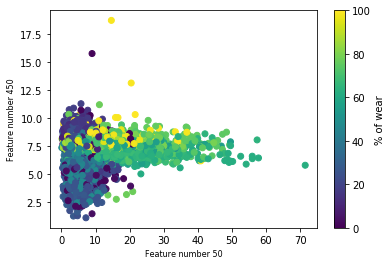

In [12]:
# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor)):
    for j in range(len(sensor_n)):
        if sensor_n[j]==i:
            top_n_features[i].append(sorted_values_from_all_sensors[i].iloc[:][feature_n[j]]);
            
# Transforming elements of sublists into lists.
for i in range(len(sensor)):
    for j in range(len(top_n_features[i])):
        top_n_features[i][j]=list(top_n_features[i][j])


top_n_together=[j for i in top_n_features for j in i]  # Merging sublists into one list with all elements of all sublists.

top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
print(type(top_n_together_matrix), "\n")

# Continue working with abosulte values.
abs_top_n_together_matrix=np.abs(top_n_together_matrix)

x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]

print("\n")
plt.scatter(abs_top_n_together_matrix[x1], abs_top_n_together_matrix[x2],c=target_train_vector[0])
plt.xlabel('Feature number %s' % x1 ,fontsize=8)
plt.ylabel('Feature number %s' % x2 ,fontsize=8)
plt.colorbar().set_label('% of wear',fontsize=10 ,rotation=90)
percentage=list(range(11))
k=0
for i in range(len(sensor)):
    #print(top_n_features_matrix.shape)
    print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
    percentage[i]=len(top_n_features[i])
    k=k+len(top_n_features[i])/len(sensor_n)*100
print("----------------------------------------------------")
print("                                             %4.2f" % (k))


Percentages of features from each sensor are:


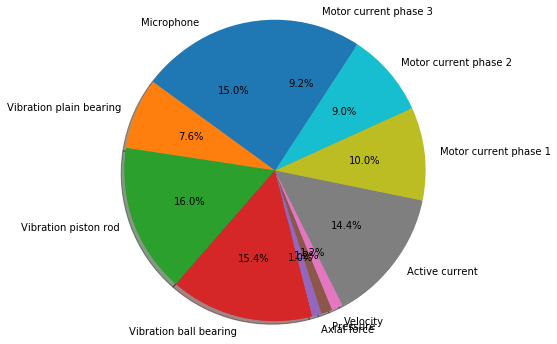

In [13]:
labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
print("Percentages of features from each sensor are:")

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(percentage, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, )
ax1.axis('equal')

plt.show()

## Classification
Classification is done in two different ways, first way is use of scikit-learn Linear Discriminant Analysis package for whole process of classification and the other way is using Linear Discriminant Analysis only for dimensionality reduction and doing classification using Mahalanobis distance calculations.

Target vector is now redefined from that used in Pearson correlation calculation and clustered by segments. It is made in order to make class labels. Classes are integers from 1 to 100 and target vector is transformed in such way that class 2 are all cycles with EMC wear between 1 and 2, including 2, but not including 1. 

In [14]:
# Definition of new target with rounding to first higher number.

class_target_train_vector=np.ceil(target_train_vector[0])

for i in class_target_train_vector.index:
    if class_target_train_vector[i]==0:
        class_target_train_vector[i]=1                #Fixing the zero element.

In [17]:
X_train = np.array(abs_top_n_together_matrix)          # Feature matrix.
y_train = np.array(class_target_train_vector)          # Target vector.

print(X_train.shape)
print(y_train.shape)


(5347, 500)
(5347,)


Classification model is going to be fitted (trained) to training data, and then that model will be used for clasification of the test set which is separated at the beggining. 

### Apply patterns for feature extraction and selection on testing data

First part of both of the classification methods is to use patterns learned to extract and select features from raw test data set. Extraction is defined by frequencies which are found on traning data using BFC, and further selection is based on the indices found with Pearason correlation method. Both of these steps can and must be done without knowing class label for test data cycles.



In [18]:
# Clustering the testing data target vector for comparing and error calculation.  
class_target_test_vector=np.ceil(target_test_vector[0])

for i in class_target_test_vector.index:
    if class_target_test_vector[i]==0:
        class_target_test_vector[i]=1                   #Fixing the zero element.

Next step is to repeat similar function as one at the beggining (chooseAndReturnOrdered), but this time extraction is done with known frequencies of interest which were found at the beggining. 

In [19]:
#Extracting features from test data with defined frequencies.

def extractFromTesting(sensor_test, frequencies, n_of_samples, N): 
    x_measurements=range(sensor_test.shape[0])            # Number of measurements in time period.Working only inside the loop!
    x = np.true_divide(x_measurements, n_of_samples)      # Time values, can be used as real time axis.
    freq = np.fft.rfftfreq(x.size, 0.0005)                # Frequency axis, can be used for plotin in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor_test,n_of_samples,0)   # Ndarray of amplitudes after fourier transform.
    fft_matrix = pd.DataFrame(fft_amplitudes)             # Transforming amplitudes into data frame (matrix)-
    #-----------------------------------------------------# -where one column represents amplitudes of one-
    #-----------------------------------------------------# -cycle.
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.

    n_rows, n_columns = np.shape(fft_matrix)

    print("\nNumber of cycles is: %s, and number of features is: %s \n" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies.
    
    print("Frequencies are:\n\n %s" % frequencies.values)
    
    sorted_values_matrix_test=fft_matrix.loc[:, frequencies.loc[0,:]]

    n_rows, n_columns = np.shape(sorted_values_matrix_test)
    print("\nNumber of cycles is: %s, and number of selected features is: %s \n\n" % (n_rows, n_columns))
    
    sorted_values_matrix_test.columns=range(len(sorted_values_matrix_test.columns))
    
    return sorted_values_matrix_test;


In [20]:
# Storing selected features from the test data into a list "sorted_values_test"
sorted_values_test=[0]*len(sensor_test)

for i in range(len(sensor_test)):         
    print("Sensor number %s" % i)
    print("---------------------------------------------------------------------------------")
    sorted_values_test[i]=extractFromTesting(sensor_test[i], freq_of_sorted_values[i], n_of_samples, N)

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 944, and number of features is: 1001 

Frequencies are:

 [[  0. 480.  85. 640.   1. 100. 120.   2.   3.   6. 123.   4.  82. 121.
   40.   5. 440. 818. 479. 819.   7. 815. 817. 816. 119. 827. 820.  27.
  814. 760. 127. 811. 812. 200. 124. 813. 828. 821.  84. 810. 822. 826.
  825. 695. 835. 824. 834. 990. 761. 809. 823. 833. 832. 836.  70.  24.
  724. 808. 807. 831.  80. 829. 830.  69. 800. 694.  41. 806.  29. 801.
  109. 762. 837. 720. 696. 697. 793. 805. 160. 148.  30.  71. 766. 804.
  989. 122.  28. 799.   8.  83. 149.  86.  25. 839. 128.  68. 407. 759.
  838.  42.]]

Number of cycles is: 944, and number of selected features is: 100 


Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 944, and number of features is: 1001 

Frequencies are:

 [[480.  80. 479.  79.   2. 481.  78.   0.  40. 120.  77.

_Example of test set features extracted from microphone using pattern from the best Fourier coefficients method._

In [21]:
#sorted_values_test[0]

Now, we need to select features out of these using pattern from section Feature selection (Pearson correlation).
Same part of the code can be used to select features with indices defined earlier.


In [22]:
# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_test=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor_test)):
    for j in range(len(sensor_n)):
        if sensor_n[j]==i:
            top_n_test[i].append(sorted_values_test[i].iloc[:][feature_n[j]]);
            
# Transforming elements of sublists into lists.
for i in range(len(sensor)):
    for j in range(len(top_n_test[i])):
        top_n_test[i][j]=list(top_n_test[i][j])


top_n_test_together=[j for i in top_n_test for j in i]  # Merging sublists into one list with all elements of all sublists.

top_n_test_together=np.transpose(pd.DataFrame(top_n_test_together))

# Continue working with abosulte values.
abs_top_n_test_together=np.abs(top_n_test_together)



Array "X_test" is main feature matrix for testing data which will be used for predictions, and correct class labels for this data is array "y_test".

In [23]:
X_test = np.array(abs_top_n_test_together)          # Feature matrix.
y_test = np.array(class_target_test_vector)          # Target vector.

print(X_test.shape)
print(y_test.shape)



(944, 500)
(944,)


### Classification using Linear Discriminant Analysis

First example is just starting with LDA and using fit_transform() function of LDA. In this step, only traning data is used, feature matrix is fitted to target vector and transformed into features of first three discriminant functions. 

Description of this method and more practical examples can be found here: https://scikit-learn.org/stable/modules/lda_qda.html, but the overall idea is the projection of data onto the most discriminant directions which can be seen on the next picture [5]:

<img src="Pictures/lda.png" width="600">

One more example of some features correlating is in the left graph, and a plot of first two discriminant functions is on the right side. Colors on these grapsh represent class labels for features.  




(5347, 3)


<Figure size 432x288 with 0 Axes>

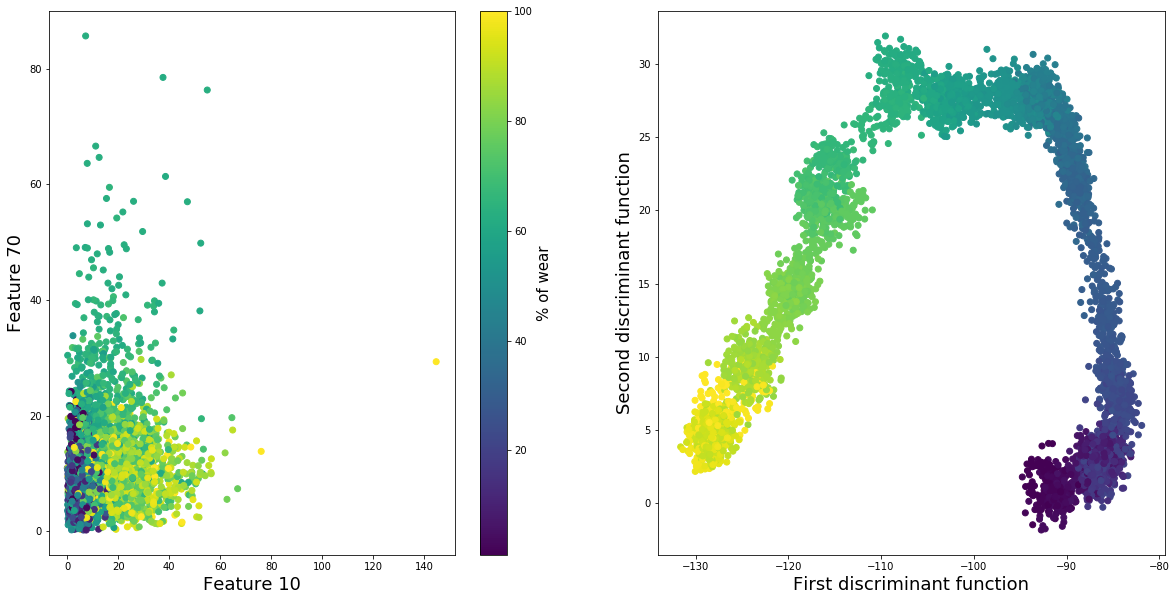

In [24]:
#LDA analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
                                        
LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='eigen')

Y_train=LDA1.fit_transform(X_train,y_train)

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_train[:,9], X_train[:,69], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Feature 10", fontsize=18)
plt.ylabel("Feature 70", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(Y_train[:,0], Y_train[:,1], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

print(Y_train.shape)                                        # Discrimnant functions matrix

plt.show()


Also, it is posible to plot more discriminant functions, for example first and third on the right plot, and second and third on the left.

<Figure size 432x288 with 0 Axes>

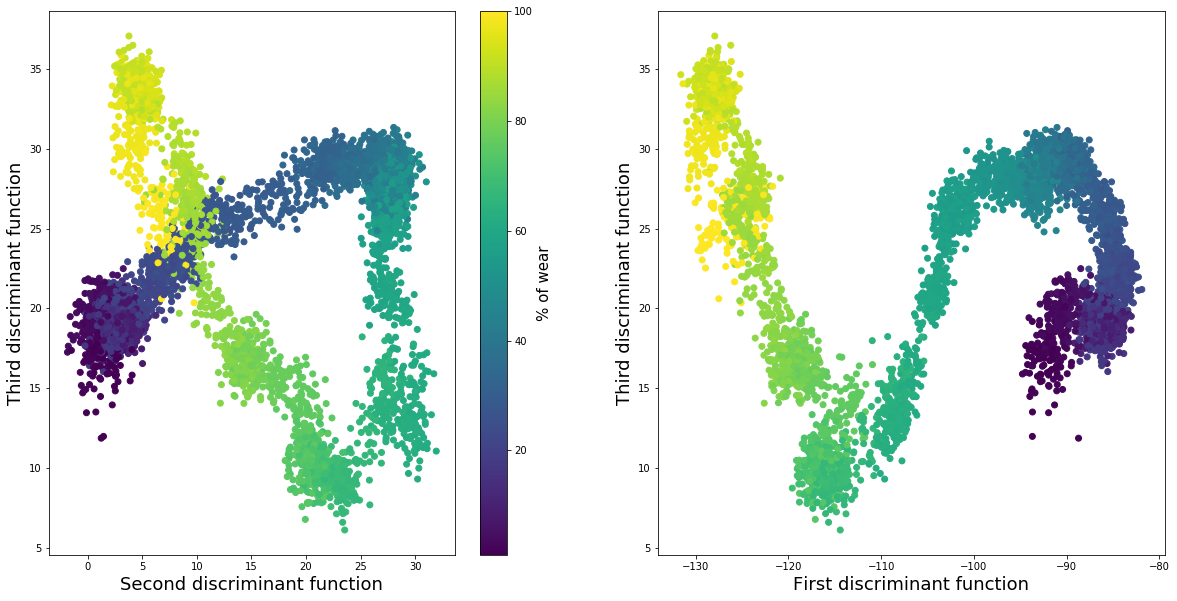

In [25]:
# Ploting first three dicriminant functions.
plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(Y_train[:,1], Y_train[:,2], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("Second discriminant function", fontsize=18)
plt.ylabel("Third discriminant function", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(Y_train[:,0], Y_train[:,2], c=y_train)                   #(X[:,0], X[:,1],c=np.arange(y))
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Third discriminant function", fontsize=18)


plt.show()

Nice possibility is also to plot 3D scatter of first three discriminant function, which can, just as plots before, show patterns and potential for classificiation.

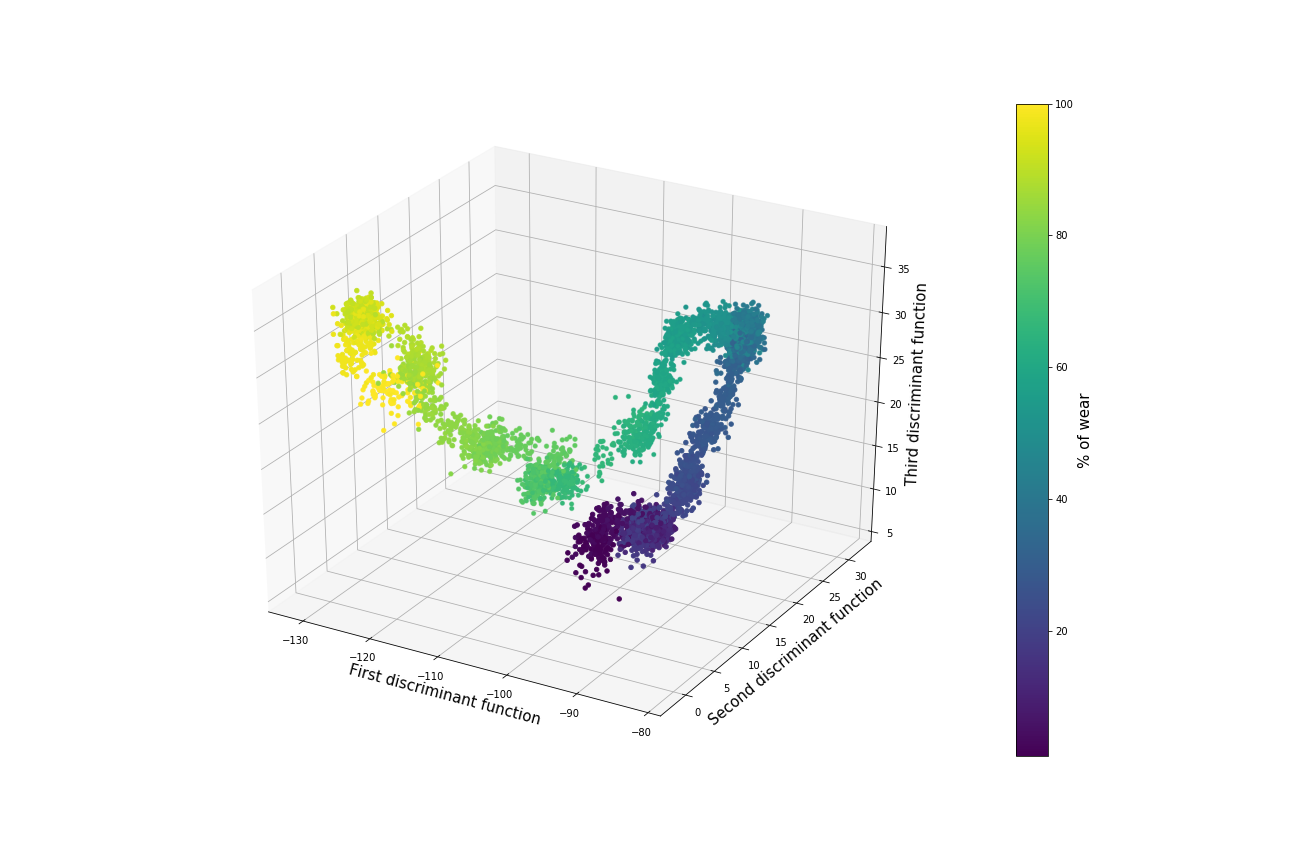

[52.] 51.0


In [26]:
# Ploting 3D with 3 discriminant functions
from mpl_toolkits.mplot3d import Axes3D #as ax

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


fig=plt.figure(figsize=(18,12))

ax = fig.gca(projection='3d')
p=ax.scatter(Y_train[:,0], Y_train[:,1], Y_train[:,2], c=y_train)
ax.set_xlabel("First discriminant function", fontsize=15)
ax.set_ylabel("Second discriminant function", fontsize=15)
ax.set_zlabel("Third discriminant function", fontsize=15)
fig.colorbar(p).set_label('% of wear',fontsize=15 ,rotation=90)

plt.show()

# 
print(LDA1.predict([X_train[3150,:]]), y_train[3150])

Now, testing data will be predicted with trained algorithm LDA1.

LDA function predict(), which is used here, predicts class labels for observations in testing data set. Prediction error is calculated as difference between estimated and real percentage of EMC wear. That error is plotted in a graph below. 

Another LDA function that does the similiar thing is used, it is function score() which gives the overall score of how  good class label prediction for testing data set.   

Size of training dataset is:  (5347, 500)
Size of testing dataset is:  (944, 500) 

Example of predicting class for only one observation: 

Predicted class is 26.0, and the real class is 26.0 

Root mean squared error of classification is: 0.49787684815846117  %.

Overall score of LDA predict is: 0.8315677966101694


Error is showed as a function of real class for all 944 testing cycles.


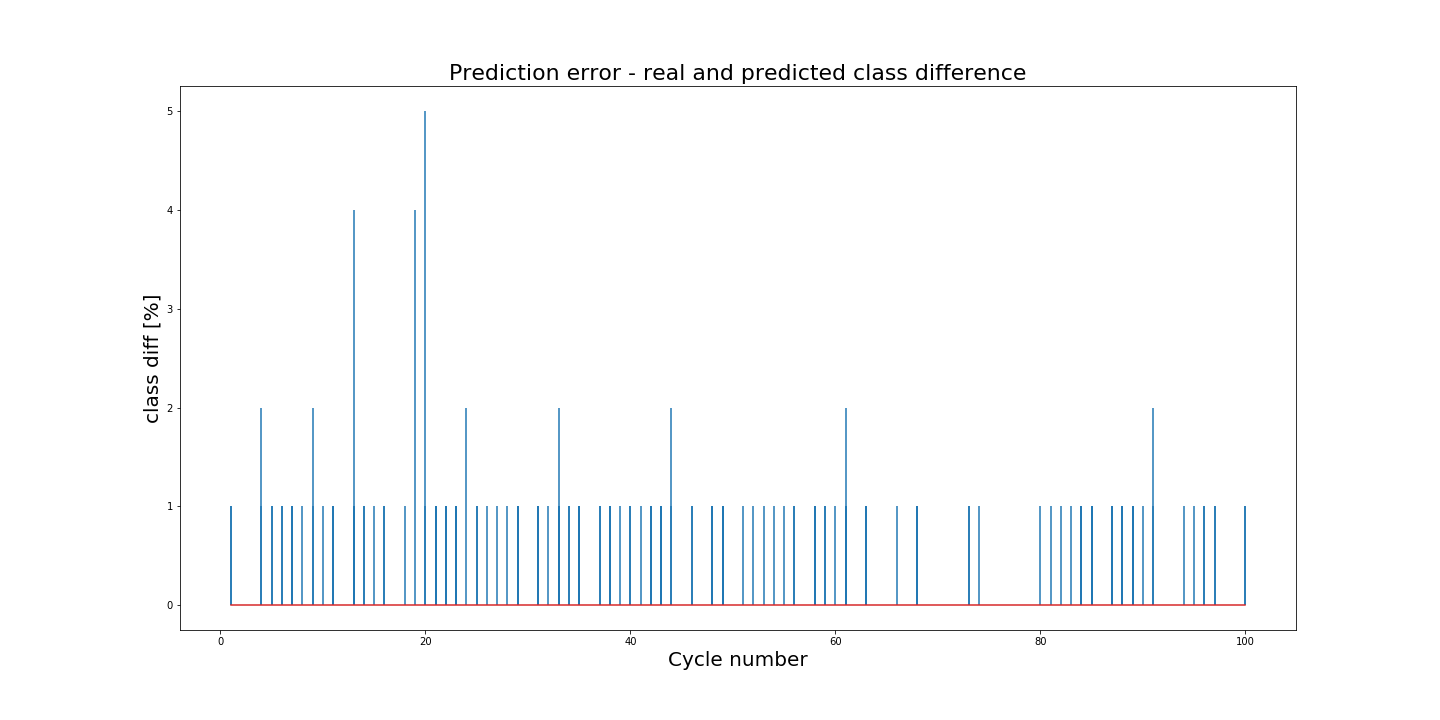

In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print("Size of training dataset is: ", X_train.shape)
print("Size of testing dataset is: ", X_test.shape, "\n")

error_LDA1=np.abs((LDA1.predict(X_test))-y_test[:])
plt.figure(figsize=(20,10))
plt.stem(y_test[:], error_LDA1, use_line_collection=True,  markerfmt=' ')
plt.xlabel("Cycle number", size='20')
plt.ylabel("class diff [%]", size='20')
plt.title('Prediction error - real and predicted class difference', size='22')

print("Example of predicting class for only one observation: \n")
print("Predicted class is %s, and the real class is %s \n" % ((LDA1.predict([X_test[300,:]]))[0], y_test[300]))

rmse_lda=sqrt(mean_squared_error((LDA1.predict(X_test)),y_test[:]))

print("Root mean squared error of classification is:", rmse_lda, " %.\n")

print("Overall score of LDA predict is: %s" % LDA1.score(X_test, y_test))

print("\n\nError is showed as a function of real class for all %s testing cycles." % (y_test[:].shape))

After looking at the prediction error graph, we see that it is easier to predict percentages of wear bigger than 50%.

### Classification using Mahalanobis distance criterion with LDA for dimensionality reduction

##### Mahalanobis distance

   • The Mahalanobis distance is a measure of the distance between two points $x$ and $µ$ where the dispersion (i.e. the covariance structure) of the samples is taken into account.
   
   • The dispersion is considered through covariance matrix.

This is formally expressed as [5]:

<img src="Pictures/formula2.png">

_Intuitions:_

   • Distances along the principal directions of dispersion are contracted since they correspond to likely dispersion
of points.

   • Distances othogonal to the principal directions of dispersion are dilated since they correspond to unlikely dispersion of points.




<img src="Pictures/mahalanobis.png" width="600">


This classification methos is using Linear Discriminant Analysis to reduce the given amount of variables (features) into small number of variables by projecting them to the most discriminative directions. This method maximizes the separation between classes. For that reduced number of variables classification is done by calculation of Mahalanobis distance from the central point of each class. Prediction of class for one observation is made by comparing Mahalanobis distances for all classes and based on those values,it is concluded in which class that instance belong. 

First step in this method is to reduce the number of varibables using Linear Discriminant Analysis. Number of features selected using Pearson correlation method can be reduced with LDA to desired number of most discriminative functions which replace all the features.

It is first used for the training data with respect to target vector, and that function is scikit-learn's fit(). The function transform() is used for test-data to transform it with trained algorithm without the target vector referencing to.

Plots are made for train and test data, but since classification is not yet done for the test data, colors in the right plot are informations about real classes for test data and plots colored with predicted class will be made after classification.


In this example Mahalanobis distance calculation is done in this way. All observations from the traning data are separated into different groups, and all elements in one group are with unique class. So, number of groups is equal to number of classes in the target vector. Then, for every observation in the test data, Mahalanobis distance from every group's center is calculated. Class for one test observation is the class of the group whose central point is nearest to observation point.

In some respects, points can be visualised in two or three-dimensional graphs, but not all informations are shown in those graphs if dimensionality reduction gives more that 3 variables.

Number of features in data is:  500 

Number of observations in training data is:  5347 

Number of observations in test data is:  944 

Type number of components you want after dimensionality reduction (1-500) (for expecting good results, number of components should be around 20):20
X_train dimensions before dimensonality reduction:  (5347, 500)
X_train_dim_reduced dimensions after dimensonality reduction:  (5347, 20)
X_test dimensions before dimensonality reduction:  (944, 500)
X_test_dim_reduced dimensions after dimensonality reduction:  (944, 20)


<Figure size 432x288 with 0 Axes>

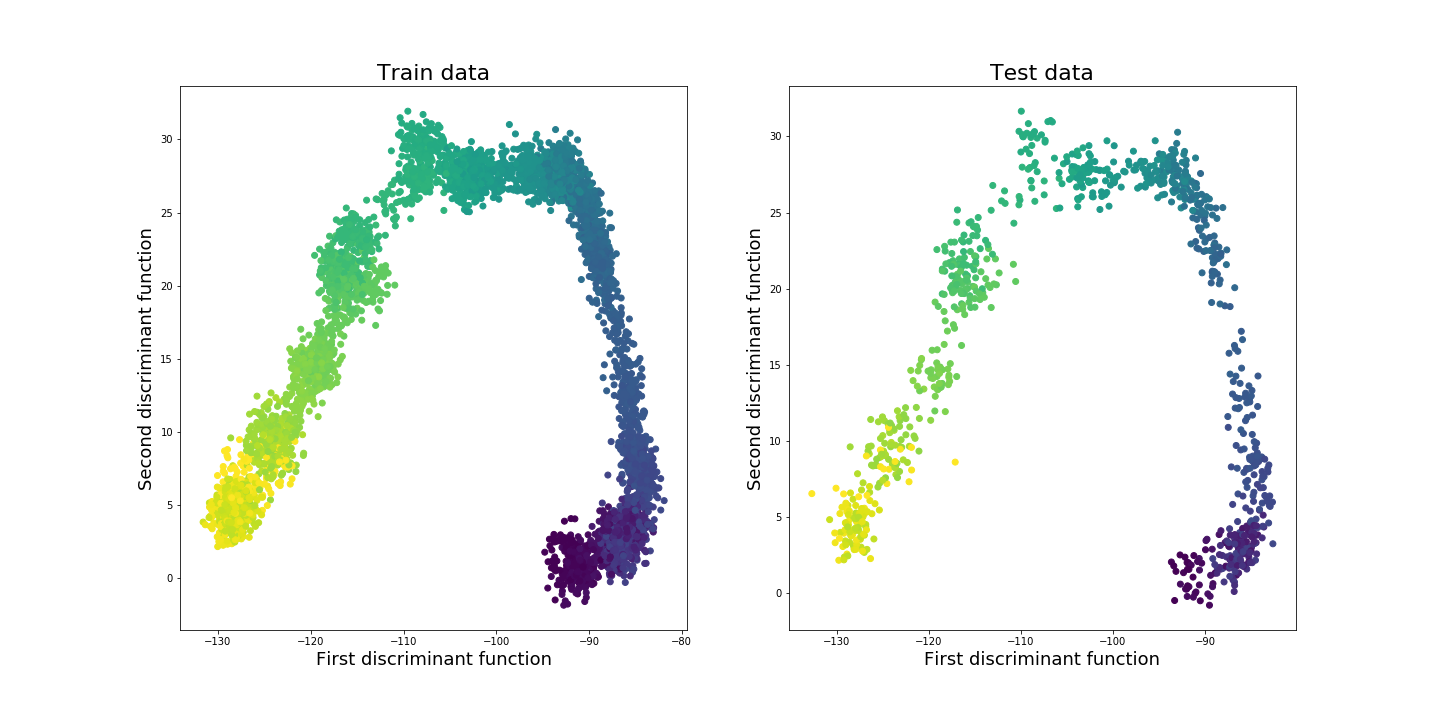

In [29]:
# Preparation of features for Mahalanobis distance classification method.

print("Number of features in data is: ",X_train.shape[1],"\n")
print("Number of observations in training data is: ",X_train.shape[0],"\n")
print("Number of observations in test data is: ",X_test.shape[0],"\n")

n_comp = input("Type number of components you want after dimensionality reduction (1-500) (for expecting good results, number of components should be around 20):" )
n_comp = int(n_comp)

# Applying LDA dimensionality reduction to train data, with respect to target vector.

dimen_reduction= LinearDiscriminantAnalysis(n_components=n_comp,priors=None,shrinkage=None,solver='eigen', store_covariance=False, tol=0.0001)

print("X_train dimensions before dimensonality reduction: ", X_train.shape)
X_train_dim_reduced = dimen_reduction.fit_transform(X_train, y_train)  
print("X_train_dim_reduced dimensions after dimensonality reduction: ", X_train_dim_reduced.shape)

# Applying LDA dimensionality reduction to the test data.

print("X_test dimensions before dimensonality reduction: ", X_test.shape)
X_test_dim_reduced = dimen_reduction.transform(X_test)
print("X_test_dim_reduced dimensions after dimensonality reduction: ", X_test_dim_reduced.shape)

# Ploting first two discriminant functions for train and test data. 

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_train_dim_reduced[:,0], X_train_dim_reduced[:,1], c=y_train)      #(X[:,0], X[:,1],c=np.arange(y))
plt.title('Train data', fontsize=22)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

plt.subplot(122)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=y_test)
plt.title('Test data', fontsize=22)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

plt.show()

In [30]:
# Function for Mahalanobis distance classification

from sklearn.covariance import EmpiricalCovariance, MinCovDet

def mahalanobisClassify(X_train, y_train, X_test, y_test):
    
    #print("Unique elements in target matrix i.e. label classes are: \n\n",np.unique(y_train),"\n")
    
    unique_elements, counts = np.unique(y_train, return_counts=True)
    
    # Initialising list for Mahalanobis distance calculation.
    X_train_splitted=list(np.zeros(len(np.unique(y_train))))
    
    # Initialising 100 matrices (one for each class label) in list "X_train_splitted".
    for i in range(len(counts)):
        X_train_splitted[i]=np.zeros((counts[i],X_train.shape[1])) 
                                                   # Counts[i] = number of rows for each class.
                                                   # Y_train.shape[1] = number of columns (same for every class).
    
    # Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

    # Filling matrices for each class with coresponding observations. 
    for j in np.int_(unique_elements):
        k=0
        for i in range(len(y_train)):
            if y_train[i]==j:   
                X_train_splitted[int(np.where(unique_elements==j)[0])][k,:]=X_train[i,:] # j-1
                k=k+1
    
    X_mahal_distances=np.zeros((len(X_test),len(unique_elements)))
    #print(Y_mahal_distances.shape)

    for i in np.int_(unique_elements):
        robust_cov = MinCovDet().fit(X_train_splitted[int(np.where(unique_elements==i)[0])])
        X_mahal_distances[:,int(np.where(unique_elements==i)[0])] = robust_cov.mahalanobis(X_test)     # j-1
    
    print(X_mahal_distances.shape)
    predicted = np.argmin(X_mahal_distances, axis=1)         # Finds the indices of minimum values from each row.
    predicted_class = predicted+1
    
    #print(predicted_class)
    #print(y_test)

    error=np.abs(predicted_class-y_test)
    
    print("\n\nError is showed as a function of real class for all %s testing cycles." % (y_test[:].shape))
    plt.figure(figsize=(20,10))
    plt.stem(y_test, error, use_line_collection=True,  markerfmt=' ')
    plt.xlabel("Cycle number", size='20')
    plt.ylabel("class diff [%]", size='20')
    plt.title('Prediction error - real and predicted class difference', size='22')
    
    RMSE=sqrt(mean_squared_error(y_test,predicted_class))
    
    return predicted_class, error, RMSE


(944, 100)


Error is showed as a function of real class for all 944 testing cycles.
Root mean squared error of classification is: 1.1576019924314902 %.


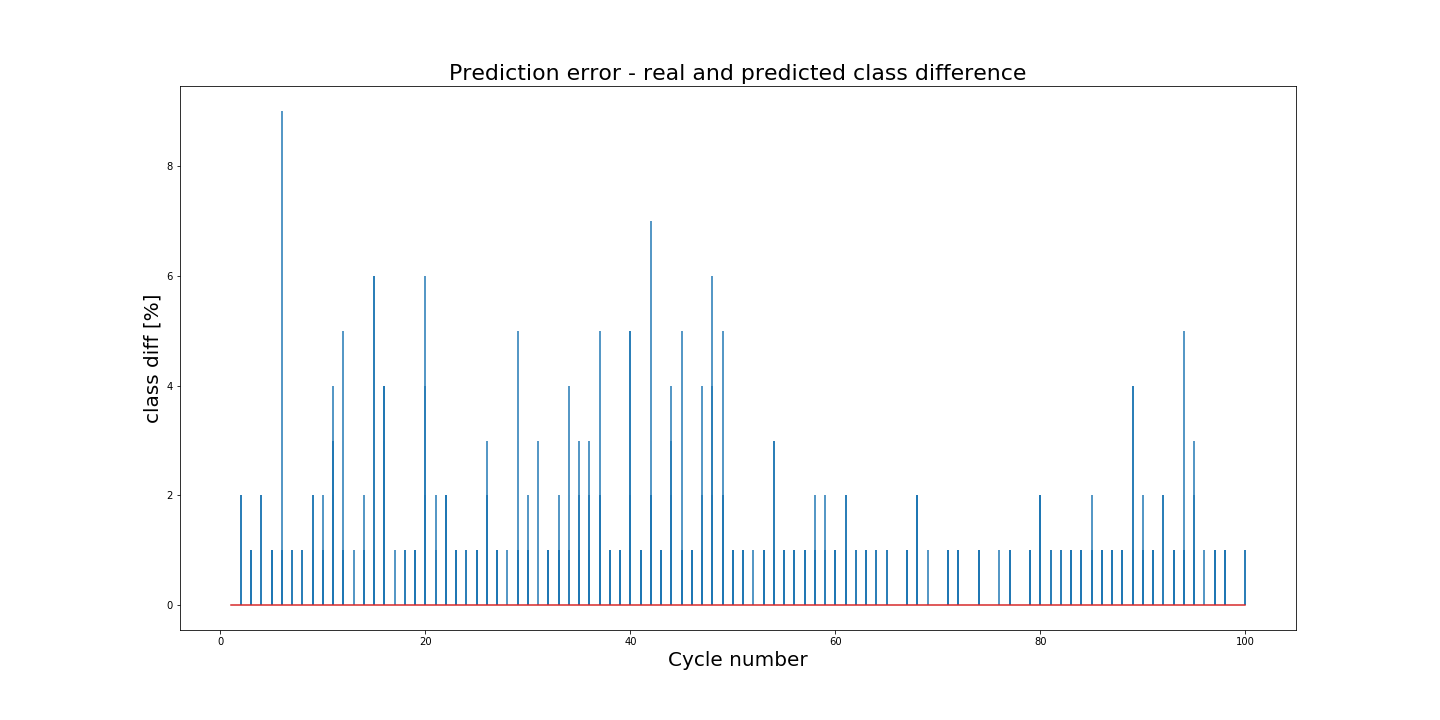

In [31]:

predicted_class, error, RMSE = mahalanobisClassify(X_train_dim_reduced, y_train, X_test_dim_reduced, y_test)

print("Root mean squared error of classification is:", RMSE, "%.")

#for i in range(100):
#    print(predicted_class[i], y_test[i])

<Figure size 432x288 with 0 Axes>

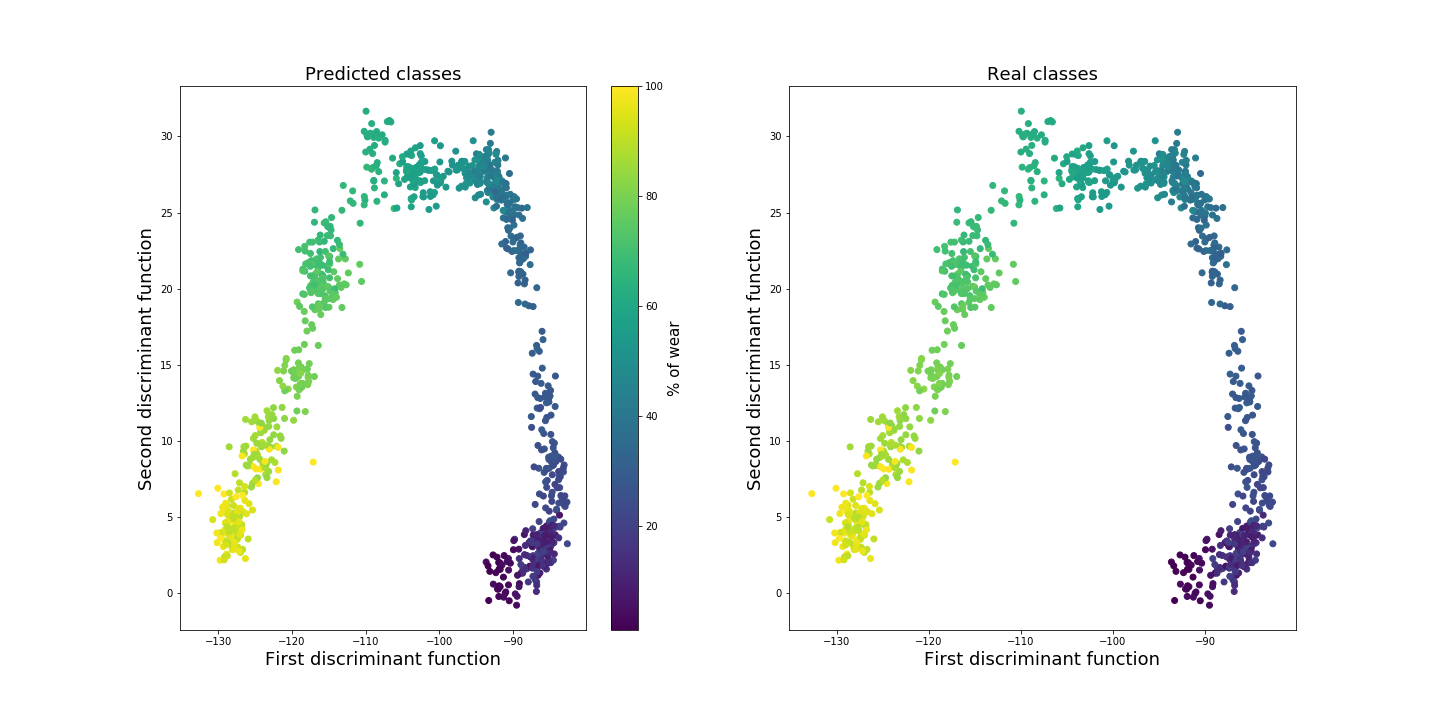

In [32]:
# Ploting first 2 discriminant functions with predicted (left) and real classes (right).
plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=predicted_class)                   
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)
plt.title("Predicted classes", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=y_test)                  
plt.title("Real classes", fontsize=18)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)


plt.show()

Now we will plot some predicted classes from testing data to show position related to traning groups.

In [33]:
unique_elements, counts = np.unique(y_train, return_counts=True)
    
#for i in range(len(unique_elements)):
#    print(unique_elements[i], counts[i])
    
# Initialising list for Mahalanobis distance calculation.
X_train_splitted=list(np.zeros(len(np.unique(y_train))))
    
# Initialising 100 matrices (one for each class label) in list "X_train_splitted".
for i in range(len(counts)):
    X_train_splitted[i]=np.zeros((counts[i],X_train_dim_reduced.shape[1])) 
                                        # Counts[i] = number of rows for each class.
                                        # Y_train_dim_reduced.shape[1] = number of columns (same for every class).
    
# Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

# Filling matrices for each class with coresponding observations.
# This loop checks all rows in training data-set, then checks class for that row, and based on that class,
# puts that row into different groups.
for j in np.int_(unique_elements):
    k=0
    for i in range(len(y_train)):
        if y_train[i]==j:   
            X_train_splitted[int(np.where(unique_elements==j)[0])][k,:]=X_train_dim_reduced[i,:] # j-1
            k=k+1

Some of the classes will be plotted to ilustrate how good this prediction was. Scatter points colored gray to black are training samples for classes, and colored are predicted samples from testing data.

Text(0, 0.5, 'Second discriminant function')

<Figure size 432x288 with 0 Axes>

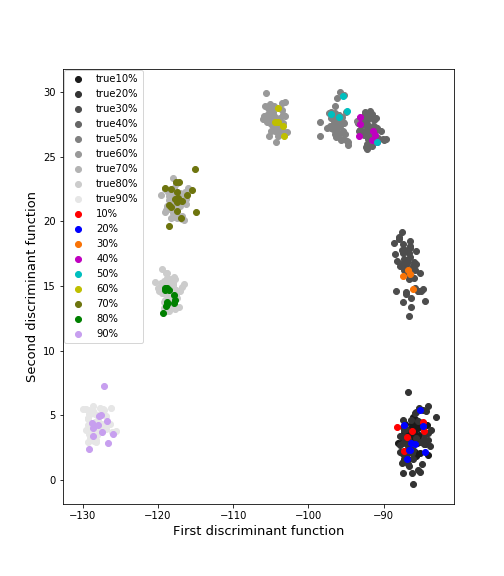

In [37]:
unique_elements_test, counts_test = np.unique(predicted_class, return_counts=True)
    
#for i in range(len(unique_elements_test)):
#    print(unique_elements_test[i], counts_test[i])
    
# Initialising list for Mahalanobis distance calculation.
X_test_splitted=list(np.zeros(len(np.unique(predicted_class))))
    
# Initialising 100 matrices (one for each class label) in list "X_train_splitted".
for i in range(len(counts_test)):
    X_test_splitted[i]=np.zeros((counts_test[i],X_test_dim_reduced.shape[1])) 
    
# Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

# Filling matrices for each class with coresponding observations.
# This loop checks all rows in training data-set, then checks class for that row, and based on that class,
# puts that row into different groups.
for j in np.int_(unique_elements_test):
    k=0
    for i in range(len(predicted_class)):
        if predicted_class[i]==j:   
            X_test_splitted[int(np.where(unique_elements_test==j)[0])][k,:]=X_test_dim_reduced[i,:] # j-1
            k=k+1

plt.figure(1)
plt.figure(figsize=(7,8))    

colors=['0.1','0.2','0.3','0.4','0.5', '0.6','0.7','0.8','0.9','1'] # 'm', 'y'
col=0
for i in range(10,100,10):
    plt.scatter(X_train_splitted[i-1][:,0],X_train_splitted[i-1][:,1], color=colors[col], label='true'+str(i)+'%')
    col=col+1


colors=['r', 'blue', 'xkcd:orange', 'm', 'c', 'y', 'xkcd:olive', 'g', 'xkcd:lavender', 'xkcd:khaki']
col=0
for i in range(10,100,10):
    plt.scatter(X_test_splitted[i-1][:,0],X_test_splitted[i-1][:,1], color=colors[col], label=str(i)+'%')
    col=col+1
plt.legend(loc='upper left',  bbox_to_anchor=(-0.01, 1.01, 0, 0))
plt.xlabel("First discriminant function", fontsize=13)
plt.ylabel("Second discriminant function", fontsize=13)


### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018


